# Scratch Implementation of LDA in python #

In this notebook, I will be implementing Linear Discriminant Analysis(LDA) in python. LDA is a dimensionality reduction technique where the labels of each datapoint are also considered. The main aim is to project our data points onto a lower dimensionality space while making sure that there is good class-separability. We still consider our Principal Components, much like in PCA, but we want to make sure that separation between classes is considered.

LDA is a supervised in nature, meaning each datapoint will have a label associated with it.

The dataset we will be using will be the well-known iris dataset for the sake of simplicity and easy verifcation.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'
iris = datasets.load_iris()
df = pd.DataFrame(iris.data)
df.columns = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]

In [2]:
mean_vector = []

for column in df.columns:
    values = df[str(column)].values
    mean_vector.append(np.mean(values))
    
matrix = np.array(df.values)
df['targets'] = iris.target

In [3]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,targets
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# Generating class-wise Mean Vectors
classws_mean_df = df.groupby(by="targets").mean()
classws_mean_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
targets,,,,
0,5.006,3.428,1.462,0.246
1,5.936,2.770,4.260,1.326
2,6.588,2.974,5.552,2.026


In [5]:
# Calculating Overall Mean-Vector

total_mean_df = pd.DataFrame(df.mean())
total_mean_df = pd.pivot_table(total_mean_df, columns = total_mean_df.index)
total_mean_df.drop(columns=["targets"],inplace=True)
total_mean_df = total_mean_df[df.columns[:-1]]
total_mean_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.843333,3.057333,3.758,1.199333


In [6]:
# Creating a separate standardized dataframe by subtrcting 
# the mean from each respective feature

std_df = df

std_df[abs(std_df["targets"]==0)] = df[df["targets"]==0].sub(classws_mean_df.iloc[0,:]);
std_df[abs(std_df["targets"]==1)] = df[df["targets"]==1].sub(classws_mean_df.iloc[1,:]);
std_df[abs(std_df["targets"]==2)] = df[df["targets"]==2].sub(classws_mean_df.iloc[2,:]);
std_df["targets"] = iris.target
std_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,targets
0,-0.062,-0.046,0.094,0.072,0
1,-0.062,-0.046,-0.106,-0.428,0
2,-0.162,-0.046,-0.306,-0.228,0
3,0.038,-0.046,-0.406,-0.328,0
4,-0.062,-0.046,-0.006,0.172,0


1] Calculate Within Class Scatter Matrix

In [7]:
# Calculating Within Class Scatter Matrix: Sw

Sw = np.zeros((4,4))
class_list = df["targets"].unique()

for class_ in class_list:
    class_df = std_df[std_df["targets"]==class_]
    class_df.drop(columns=["targets"],inplace=True)
    val = class_df.values
    for vec in val:
        m1, m2 = vec.reshape(4,1), vec.reshape(4,1)
        class_scatter_matrix = m1.dot((m2).T)
        Sw += class_scatter_matrix
print(Sw)

[[27.2226  6.2718 24.6246  8.1208]
 [ 6.2718  6.1566  5.645   4.8084]
 [24.6246  5.645  38.9562 13.63  ]
 [ 8.1208  4.8084 13.63   16.962 ]]


2] Calculate Between Class Scatter Matrix

In [8]:
# Calculating Between Class Scatter Matrix: Sb

Sb = np.zeros((4,4))

class_mean_arr = classws_mean_df.values
total_mean_arr = total_mean_df.values

class_list = df["targets"].unique()
class_size_arr = []
for class_ in class_list:
    class_size = df[df["targets"]==class_].shape[0]
    class_size_arr.append(class_size)
    
for n, vec in zip(class_size_arr, class_mean_arr):
    m = (vec-total_mean_arr).reshape(4,1)
    m = m.dot(m.T)
    Sb += n*m
print(Sb)

[[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


3] Calculate the Eigen-Values, Eigen-Vectors 

In [9]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

In [10]:
eig_vecs

array([[ 0.1024577 , -0.13949964,  0.87312082,  0.51512604],
       [ 0.8438    ,  0.97459142, -0.34260112, -0.44319214],
       [-0.44890054,  0.15911116, -0.33177482, -0.48717117],
       [-0.27566697,  0.07345097, -0.1010444 ,  0.54853453]])

In [11]:
eig_vals

array([ 1.99928020e+01,  4.78024255e-01,  1.87587274e-15, -2.17619416e-15])

In [12]:
#Choosing the top 2 eigenvectors:
selected_eigen_vectors = eig_vecs[:,:2]
print(selected_eigen_vectors)

[[ 0.1024577  -0.13949964]
 [ 0.8438      0.97459142]
 [-0.44890054  0.15911116]
 [-0.27566697  0.07345097]]


Reconstructing our Matrix to show the lower dimensional space

In [14]:
reduced_data = np.dot(matrix, selected_eigen_vectors)
reducedDf = pd.DataFrame(reduced_data, columns =['dim1', 'dim2'])

In [15]:
reducedDf['species'] = iris.target
reducedDf.reset_index();
color_dict = dict({0:'blue', 1:'organge', 2:'red'})

In [16]:
reducedDf

,dim1,dim2,species
0,2.792240,2.937068,0
1,2.349849,2.477672,0
2,2.543007,2.684579,0
3,2.358601,2.632892,0
4,2.866374,3.048477,0
...,...,...,...
145,0.249550,2.985442,2
146,-0.013286,2.492743,2
147,0.311758,2.991307,2
148,0.446061,3.476851,2


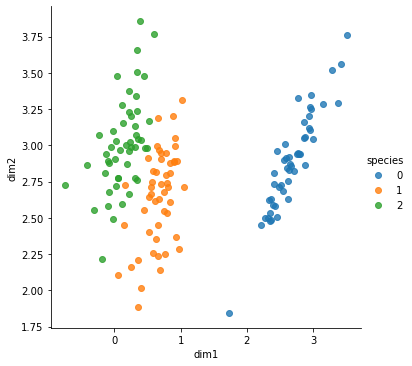

In [17]:
import seaborn as sns
sns.lmplot(data=reducedDf, x='dim1', y='dim2', hue='species', fit_reg=False)